In [1]:
#Importing the required libraies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report, roc_auc_score,roc_curve
from sklearn.preprocessing import StandardScaler, Binarizer, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

In [12]:
#Reading the given data sets 
train_data = pd.read_csv('Trainset.csv')
test_data = pd.read_csv('xtest.csv')
sample_submission = pd.read_csv('sample_submisison.csv')

In [26]:
cat_cols = ['Month','OperatingSystems','Browser','Province','TrafficType','VisitorType','Weekend']
target = 'Revenue'
change_cols = ['Homepage _Duration','Aboutus_Duration','Contactus_Duration']
num_cols = [col for col in train_data.columns.tolist() if col not in cat_cols +[target]]

## Exploratory Data Analysis

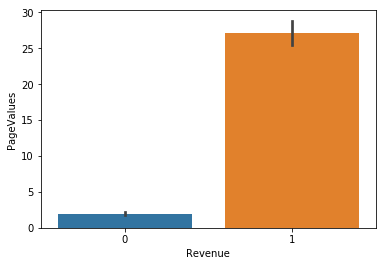

In [18]:
PV_vs_Revenue = sns.barplot('Revenue','PageValues',data = train_data)

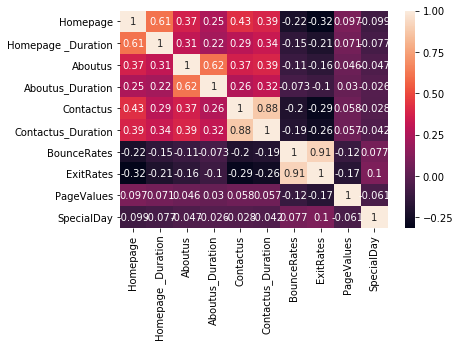

In [25]:
sns.heatmap(train_data[num_cols].corr(),annot=True)

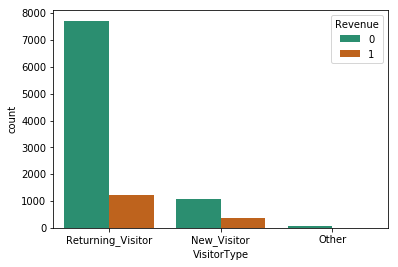

In [7]:
sns.countplot(x = 'VisitorType', data = train_data,hue='Revenue',palette="Dark2")

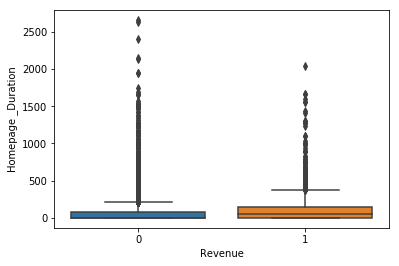

In [14]:
sns.boxplot('Revenue', 'Homepage _Duration', data = train_data)
#Data is widely spread

### Imputing Missing Values with Mean

In [15]:
for col in num_cols[:8]:
    train_data[col] = train_data[col].fillna(np.mean(train_data[col]))

### Label Encoding

In [16]:
label_encoder = LabelEncoder()
for col in cat_cols:
    train_data[col] = label_encoder.fit_transform(train_data[col])
    test_data[col] = label_encoder.transform(test_data[col])

### Analysis Using PCA

C:\Users\Aflal Afham\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Aflal Afham\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Analysis using PCA')

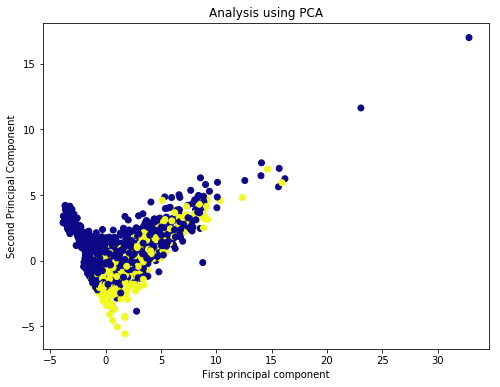

In [17]:
X = train_data.drop('Revenue',axis = 1)
scaler = StandardScaler()
scaler.fit(X)
scaled_data = scaler.transform(X)

pca = PCA(n_components=2)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)

plt.figure(figsize=(8,6))
plt.scatter(pca_data[:,0],pca_data[:,1],c=train_data['Revenue'],cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.title('Analysis using PCA')

## Feature Engineering

    Taking the log values of 'Homepage _Duration','Aboutus_Duration','Contactus_Duation' in order to avoid the effect of outliers by vairance.

In [27]:
def ln_func(col):
    if col<=1:
        return 0
    else:
        return np.log(col)
for col in change_cols:
    train_data[col] = train_data[col].apply(ln_func)
    test_data[col] = test_data[col].apply(ln_func)

    Discretizing the selected variables according to the predicted probabilities of Decision Tree Classifier Method

In [28]:
tree_model = DecisionTreeClassifier(max_depth=5)
tree_model.fit(train_data['PageValues'].to_frame(), train_data['Revenue'])
train_data['PV_tree']=tree_model.predict_proba(train_data['PageValues'].to_frame())[:,1] 
test_data['PV_tree']=tree_model.predict_proba(test_data['PageValues'].to_frame())[:,1]

tree_model.fit(train_data['BounceRates'].to_frame(), train_data['Revenue'])
train_data['BR_tree']=tree_model.predict_proba(train_data['BounceRates'].to_frame())[:,1] 
test_data['BR_tree']=tree_model.predict_proba(test_data['BounceRates'].to_frame())[:,1] 

tree_model.fit(train_data['ExitRates'].to_frame(), train_data['Revenue'])
train_data['ER_tree']=tree_model.predict_proba(train_data['ExitRates'].to_frame())[:,1] 
test_data['ER_tree']=tree_model.predict_proba(test_data['ExitRates'].to_frame())[:,1] 

train_data = train_data.drop(['BounceRates','ExitRates','PageValues'],axis=1)
test_data = test_data.drop(['BounceRates','ExitRates','PageValues'],axis=1)

In [29]:
X = train_data.drop('Revenue',axis=1)
y = train_data['Revenue']
test = test_data.drop('ID',axis=1)

## Model Selection and Validation

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25)

In [31]:
model_rfc = RandomForestClassifier()
model_rfc.fit(X_train,y_train)
preds_rfc = model_rfc.predict(X_test)

print(confusion_matrix(y_test,preds_rfc))
print('\n')
print(classification_report(y_test,preds_rfc))

[[2137   79]
 [ 184  220]]


              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2216
           1       0.74      0.54      0.63       404

   micro avg       0.90      0.90      0.90      2620
   macro avg       0.83      0.75      0.78      2620
weighted avg       0.89      0.90      0.89      2620



C:\Users\Aflal Afham\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Parameters Tuning

In [33]:
param_grid = {'n_estimators': [100,200],
               'max_features': ['sqrt','auto'],
               'criterion': ['gini','entropy']}

grid = GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=3)
grid.fit(X,y)

print (grid.best_params_)
print (grid.best_score_)

C:\Users\Aflal Afham\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] criterion=gini, max_features=sqrt, n_estimators=100 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=100, score=0.9101316542644533, total=   1.1s
[CV] criterion=gini, max_features=sqrt, n_estimators=100 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  criterion=gini, max_features=sqrt, n_estimators=100, score=0.9075558099599313, total=   1.0s
[CV] criterion=gini, max_features=sqrt, n_estimators=100 .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s


[CV]  criterion=gini, max_features=sqrt, n_estimators=100, score=0.9026345933562429, total=   1.1s
[CV] criterion=gini, max_features=sqrt, n_estimators=200 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=200, score=0.912135088723526, total=   2.3s
[CV] criterion=gini, max_features=sqrt, n_estimators=200 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=200, score=0.905266170578134, total=   2.2s
[CV] criterion=gini, max_features=sqrt, n_estimators=200 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=200, score=0.9012027491408935, total=   2.1s
[CV] criterion=gini, max_features=auto, n_estimators=100 .............
[CV]  criterion=gini, max_features=auto, n_estimators=100, score=0.9107040641099027, total=   1.0s
[CV] criterion=gini, max_features=auto, n_estimators=100 .............
[CV]  criterion=gini, max_features=auto, n_estimators=100, score=0.9089868345735547, total=   1.0s
[CV] criterion=gini, max_features=auto, n_estimators=

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   53.2s finished


{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 200}
0.9097328244274809


    Selected Model => RandomForestClassifier(criterion = 'entropy', max_features = 'sqrt', n_estimators = 200)

#### KFold Cross Validation

In [40]:
print('cross_val_score: ',np.mean(cross_val_score(model_rfc,X,y,cv=5)))

cross_val_score:  0.8994266889461648


In [41]:
model_rfc = RandomForestClassifier(criterion = 'entropy', max_features = 'sqrt', n_estimators = 200)
model_rfc.fit(X_train,y_train)
preds_rfc = model_rfc.predict(X_test)

print(confusion_matrix(y_test,preds_rfc))
print('\n')
print(classification_report(y_test,preds_rfc))

[[2126   90]
 [ 158  246]]


              precision    recall  f1-score   support

           0       0.93      0.96      0.94      2216
           1       0.73      0.61      0.66       404

   micro avg       0.91      0.91      0.91      2620
   macro avg       0.83      0.78      0.80      2620
weighted avg       0.90      0.91      0.90      2620



## ROC AUC Curve

AUC: 0.926


Text(0.5, 1.0, 'ROC-AUC Curve')

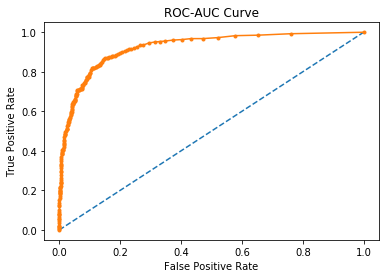

In [43]:
pred_proba = model_rfc.predict_proba(X_test)

# keep probabilities for the positive outcome only
pred_proba = pred_proba[:, 1]

# calculate AUC
auc = roc_auc_score(y_test, pred_proba)
print('AUC: %.3f' % auc)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
plt.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC-AUC Curve')